# 基于PaddleSeg的遥感地块分割

## 一、项目背景介绍
遥感影像地块分割, 旨在对遥感影像进行像素级内容解析，对遥感影像中感兴趣的类别进行提取和分类，在城乡规划、防汛救灾等领域具有很高的实用价值，在工业界也受到了广泛关注。现有的遥感影像地块分割数据处理方法局限于特定的场景和特定的数据来源，且精度无法满足需求。因此在实际应用中，仍然大量依赖于人工处理，需要消耗大量的人力、物力、财力。本项目旨在衡量遥感影像地块分割模型在多个类别（如建筑、道路、林地等）上的效果，利用人工智能技术，对多来源、多场景的异构遥感影像数据进行充分挖掘，打造高效、实用的算法，提高遥感影像的分析提取能力。

## 二、数据介绍
### [遥感影像分割——WHDLD](https://aistudio.baidu.com/aistudio/datasetdetail/55589/0)
### 数据集背景
WHDLD数据集  
- 包含6种类型的遥感地物类型  
- 提取自UC Merced  
- 由武汉大学于2018年发布  

### 数据集内容
影像信息：  
- image size: 256 * 256 * 3  
- image number: 4940  

![](https://ai-studio-static-online.cdn.bcebos.com/3d1cd30362ba41b8afa6729a5be44a00338c47c6615f49c680c68c226a7957f4)
![](https://ai-studio-static-online.cdn.bcebos.com/8a995f72b4a14cd5a2d20912d69cf99117d6aad9cd6445c9a8a1f901d826c2b8)

### 标注信息
6类

![](https://ai-studio-static-online.cdn.bcebos.com/67966da8ea174102a2f645f08b9be80497505773f1274d5494ce46aff8093b5a)

### 来源
[https://sites.google.com/view/zhouwx/dataset#h.p_hQS2jYeaFpV0](https://sites.google.com/view/zhouwx/dataset#h.p_hQS2jYeaFpV0)

### 其他说明
If you use WHDLD in any resulting publications, please cite the following works:
Shao, Z.; Yang, K.; Zhou, W. Performance Evaluation of Single-Label and Multi-Label Remote Sensing Image Retrieval Using a Dense Labeling Dataset. Remote Sens. 2018, 10(6), 964.
Shao, Z., Zhou, W., Deng, X., Zhang, M., & Cheng, Q. Multilabel Remote Sensing Image Retrieval Based on Fully Convolutional Network. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2020, 13, 318-328.

## 三、模型介绍
> References: [HardNet飞桨（Paddle）论文复现(By:Jordan2020)](https://aistudio.baidu.com/aistudio/projectdetail/1848242)

**HarDNet**指的是Harmonic DenseNet: A low memory traffic network，其突出的特点就是低内存占用率。过去几年，随着更强的计算能力和更大的数据集，我们能够训练更加复杂的网络。对于实时应用，我们面临的问题是如何在提高计算效率的同时，降低功耗。在这种情况下，作者们提出了HarDNet在两者之间寻求最佳平衡。

HarDNet可以用于图像分割、目标检测和语义分割，其架构是基于Densely Connected Network。在HarDNet中，作者提出了Harmonic Dense Bocks的概念。如下图所示，可以看到该网络就像多个谐波。HarDNet的全称就是Harmonic Densely Connected Network。  
![](https://ai-studio-static-online.cdn.bcebos.com/e3faeaed2ba74b1f867b673607332114935ec29f37d6468b99f5a7a6682df1a8)  
作者对每一层的MoC施加一个软约束，以设计一个低CIO网络模型，并合理增加MACs。如下图所示，避免使用MoC非常低的层，例如具有非常大输入/输出通道比的Conv1x1层。受Densely Connected Networks的启发，作者提出了Harmonic Densely Connected Network (HarD- Net) 。首先减少来自DenseNet的大部分层连接，以降低级联损耗。然后，通过增加层的通道宽度来平衡输入/输出通道比率。  
![](https://ai-studio-static-online.cdn.bcebos.com/ef3d058b1e0c42b583d479366eb2011252a8a0af79d041e7b63ca80c6d6d1c04)

## 四、环境安装与数据准备

### 1. PaddleSeg的安装与环境配置

In [ ]:
# 安装paddleseg，当前版本为2.4.0
!pip install -q paddleseg==2.4.0

### 2. 解压数据集

In [ ]:
# 解压训练数据集与标记
!unzip -oq /home/aistudio/data/data55589/WHDLD.zip -d data/data55589

# 查看文件目录
!tree data/data55589 -d

### 3. EISeg标注数据演示
> [EISeg官方文档](https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.2/contrib/EISeg)

EISeg(Efficient Interactive Segmentation)是基于飞桨开发的一个高效智能的交互式分割标注软件。涵盖了高精度和轻量级等不同方向的高质量交互式分割模型，方便开发者快速实现语义及实例标签的标注，降低标注成本。 另外，将EISeg获取到的标注应用到PaddleSeg提供的其他分割模型进行训练，便可得到定制化场景的高精度模型，打通分割任务从数据标注到模型训练及预测的全流程。

#### **模型准备**
在使用EIseg前，请先下载模型参数。EISeg开放了在COCO+LVIS和大规模人像数据上训练的四个标注模型，满足通用场景和人像场景的标注需求。其中模型结构对应EISeg交互工具中的网络选择模块，用户需要根据自己的场景需求选择不同的网络结构和加载参数。  
本项目选用的是[hrnet18_ocr64_cocolvis](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18_ocr64_cocolvis.pdparams)模型。
| 模型类型 | 适用场景 | 模型结构 | 下载地址|
| --- | --- | --- | ---|
| **高精度模型**  | **适用于通用场景的图像标注。** | **HRNet18_OCR64** | **[hrnet18_ocr64_cocolvis](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18_ocr64_cocolvis.pdparams)** |
| 轻量化模型  | 适用于通用场景的图像标注。 |HRNet18s_OCR48 | [hrnet18s_ocr48_cocolvis](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18s_ocr48_cocolvis.pdparams) |
| 高精度模型  | 适用于人像标注场景。 |HRNet18_OCR64 | [hrnet18_ocr64_human](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18_ocr64_human.pdparams) |
| 轻量化模型  | 适用于人像标注场景。 |HRNet18s_OCR48 | [hrnet18s_ocr48_human](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18s_ocr48_human.pdparams) |

#### **安装使用**

EISeg提供多种安装方式，其中使用[pip](#PIP)和[运行代码](#运行代码)方式可兼容Windows，Mac OS和Linux。为了避免环境冲突，推荐在conda创建的虚拟环境中安装。

版本要求:

* PaddlePaddle >= 2.1.0

PaddlePaddle安装请参考[官网](https://www.paddlepaddle.org.cn/install/quick?docurl=/documentation/docs/zh/install/pip/windows-pip.html)。

这里使用pip安装方式：

```shell
pip install eiseg
```
pip会自动安装依赖。安装完成后命令行输入：
```shell
eiseg
```
即可运行软件。

#### **使用**

打开软件后，在对项目进行标注前，需要进行如下设置：

1. **模型参数加载**

   选择合适的网络，并加载对应的模型参数。目前在EISeg中，网络分为`HRNet18s_OCR48`和`HRNet18_OCR64`，并分别提供了人像和通用两种模型参数。在正确加载模型参数后，右下角状态栏会给予说明。若网络参数与模型参数不符，将会弹出警告，此时加载失败需重新加载。正确加载的模型参数会记录在`近期模型参数`中，可以方便切换，并且下次打开软件时自动加载退出时的模型参数。

![](https://ai-studio-static-online.cdn.bcebos.com/20493e7446454ea6bc3f7648009ead3b700c8690aaee43cebedf4d97bec7125b)

2. **图像加载**

   文件$\to$打开图像/图像文件夹。当看到主界面图像正确加载，`数据列表`正确出现图像路径即可。

![](https://ai-studio-static-online.cdn.bcebos.com/0475e4cbeb274e89a970b710f12dd2c84201903098ec40b3b6dcef4e02ba203a)

3. **标签添加/加载**

   添加/加载标签。可以通过`添加标签`新建标签，标签分为4列，分别对应像素值、说明、颜色和删除。新建好的标签可以通过`保存标签列表`保存为txt文件，其他合作者可以通过`加载标签列表`将标签导入。通过加载方式导入的标签，重启软件后会自动加载。  
![](https://ai-studio-static-online.cdn.bcebos.com/893d7ec1186a48678c3b18d21ef9dc7e07e0ce5381e94ce18e873530b630a04e)


4. **自动保存设置**

   在使用中可以将`自动保存`设置上，设定好文件夹即可，这样在使用时切换图像会自动将完成标注的图像进行保存。

当设置完成后即可开始进行标注。  

![](https://ai-studio-static-online.cdn.bcebos.com/4defd4610c914422b68dd78b42df807a08e54358ea4e41a3acfc8d3ff66e45f0)


#### **动图演示**
> 因为视频演示在这里放不上去，所以直接引用了官方文档的动图。

![](https://user-images.githubusercontent.com/71769312/141130688-e1529c27-aba8-4bf7-aad8-dda49808c5c7.gif)

#### **标注效果**
![](https://ai-studio-static-online.cdn.bcebos.com/ea4a91cedd94434d88496c57ca12477ac74e0e150e374d1491fb49115e397a44)
![](https://ai-studio-static-online.cdn.bcebos.com/e7db243366364fffa35fd5d84646f4f7c1053a6f2751466fb16cc0a263d929f3)


### 4. 构造数据集

#### **修改数据集标签**
数据集提供的标注是1-6，这里改为0-5

In [ ]:
import os
from PIL import Image
from tqdm import trange
import numpy as np

relab_path = "data/data55589/WHDLD/ImagesPNG_Relabel"
if not os.path.exists(relab_path):
    os.mkdir(relab_path)  # 创建新标签的文件夹

label_dir = 'data/data55589/WHDLD/ImagesPNG'
label_dir_list = os.listdir(label_dir)
for d in trange(len(label_dir_list)):
    im = Image.open(os.path.join(label_dir,label_dir_list[d]))  # 打开图片
    width = im.size[0]  # 获取宽度
    height = im.size[1]  # 获取长度
    im = np.array(im)
    for x in range(width):
        for y in range(height):
            label_origin = im[x, y]  # 原坐标对应的标签
            if (label_origin <= 6):
                im[x, y] -= 1  # 1-6变为0-5
            else:
                print(label_origin)
    new_im = Image.fromarray(im.astype(np.uint8), mode='P')
    new_im.save(os.path.join(relab_path, label_dir_list[d]))

#### **将训练集的图像集和标注路径写入datas中并抽样可视化**
- 左：原图
- 中：原标注
- 右：修改后的标注

total: 4940


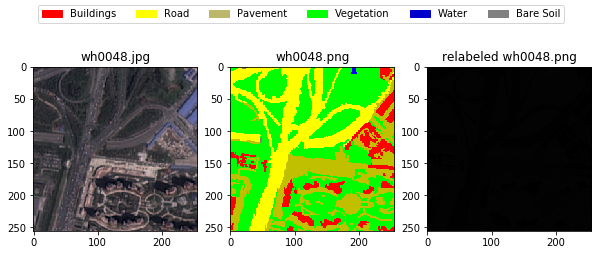

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import time
import matplotlib.patches as mpatches

datas = []
image_base = 'data/data55589/WHDLD/Images'   # 训练集原图路径
annos_base = 'data/data55589/WHDLD/ImagesPNG_Relabel'   # 训练集标签路径

# 读取原图文件名
ids_ = [v.split('.')[0] for v in os.listdir(image_base)]

# 将训练集的图像集和标签路径写入datas中
for id_ in ids_:
    img_pt0 = os.path.join(image_base, '{}.jpg'.format(id_))
    img_pt1 = os.path.join(annos_base, '{}.png'.format(id_))
    datas.append((img_pt0.replace('/home/aistudio', ''), img_pt1.replace('/home/aistudio', '')))
    if os.path.exists(img_pt0) and os.path.exists(img_pt1):
        pass
    else:
        raise Exception("path invalid!")

# 随机打乱datas
np.random.seed(int(time.time()))
np.random.shuffle(datas)

# 打印datas的长度
print('total:', len(datas))

# 抽样可视化
def visualize(path, i, title):
    img = cv2.imread(path)[:, :, ::-1]
    plt.subplot(len(datas[15]), 3, i)
    plt.title(title)
    plt.imshow(img)

fig = plt.figure(figsize=(10, 7))
# 图例
building = mpatches.Patch(color='red', label='Buildings')
road = mpatches.Patch(color='yellow', label='Road')
pavement = mpatches.Patch(color='darkkhaki', label='Pavement')
vegetation = mpatches.Patch(color='lime', label='Vegetation')
water = mpatches.Patch(color='mediumblue', label='Water')
soil = mpatches.Patch(color='grey', label='Bare Soil')
fig.legend(
    handles=[building, road, pavement, vegetation, water, soil],
    loc='upper center',
    ncol=6
)
# 显示图片
visualize(datas[15][0], 1, datas[15][0][-10:])
visualize(os.path.join("data/data55589/WHDLD/ImagesPNG", datas[15][1][-10:]), 2, datas[15][1][-10:])
visualize(datas[15][1], 3, "relabeled " + datas[15][1][-10:])

#### **将训练集、测试集图片路径写入txt文件**

In [ ]:
# 四类标签
labels = ['bare soil', 'building', 'pavement',  'road', 'vegetation', 'water']
num_classes = 6

# 将labels写入标签文件
with open('data/labels.txt', 'w') as f:
    for v in labels:
        f.write(v + '\n')

# 验证集与训练集的划分
split_num = int(0.1 * len(datas))  # 90%为训练集

# 划分训练集、验证集和测试集
train_data = datas[:-split_num]
val_data = datas[-split_num:-1]
test_data = datas[-1:]

# 写入训练集list
with open('data/train_list.txt', 'w') as f:
    for img, lbl in train_data:
        f.write(img + ' ' + lbl + '\n')

# 写入验证集list
with open('data/val_list.txt', 'w') as f:
    for img, lbl in val_data:
        f.write(img + ' ' + lbl + '\n')

# 写入测试集list
with open('data/test_list.txt', 'w') as f:
    for img, lbl in test_data:
        f.write(img + ' ' + lbl + '\n')

# 打印训练集、验证集和测试集大小
print('train:', len(train_data))
print('val:', len(val_data))
print('test:', len(test_data))

train: 4446
val: 493
test: 1


#### **构建训练集和验证集**

In [ ]:
import paddleseg.transforms as T
from paddleseg.datasets import Dataset

dataset_root = './'  # 数据集根目录
train_path = 'data/train_list.txt'  # 训练集txt文件
val_path = 'data/val_list.txt'  # 验证集txt文件

# 定义训练时的transforms
train_transforms = [
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomDistort(
        brightness_range=0.2, brightness_prob=0.5,
        contrast_range=0.2, contrast_prob=0.5,
        saturation_range=0.2, saturation_prob=0.5,
        hue_range=15, hue_prob=0.5),
    T.RandomPaddingCrop(crop_size=(256, 256)),
    T.Resize(target_size=(256, 256)),
    T.Normalize()
]
# 定义验证时的transforms
eval_transforms = [
    T.Resize((256, 256)),
    T.Normalize()
]

# 构建训练集
train_dataset = Dataset(transforms = train_transforms,
                  dataset_root = dataset_root,
                  num_classes = num_classes,
                  train_path = train_path,
                  mode = 'train')
# 构建验证集
eval_dataset = Dataset(transforms = eval_transforms,
                  dataset_root = dataset_root,
                  num_classes = num_classes,
                  val_path = val_path,
                  mode = 'val')

## 五、模型训练

### 1. 模型准备

#### **构建模型**

In [ ]:
from paddleseg.models import HarDNet

# 设置迭代次数
iters = 10000
# 设置batch_size
batch_size = 128
# 选用HarDNet模型
model = HarDNet(num_classes=num_classes)

#### **构建优化器**

In [ ]:
import paddle
import paddleseg

# 设置学习率
base_lr = 0.03
lr = paddle.optimizer.lr.PolynomialDecay(
    base_lr, 
    power=0.9, 
    decay_steps=iters, 
    end_lr=0
)
# 设置优化器
optimizer = paddle.optimizer.Momentum(
    lr, 
    parameters=model.parameters(), 
    momentum=0.9, 
    weight_decay=4.0e-5
)

#### **构建损失函数**

In [ ]:
from paddleseg.models.losses import CrossEntropyLoss

# 使用交叉熵损失函数
losses = {}
losses['types'] = [CrossEntropyLoss()]
losses['coef'] = [1]

### 2. 模型训练

In [14]:
# 模型训练
from paddleseg.core import train
train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=eval_dataset,
    optimizer=optimizer,
    save_dir='output',
    iters=iters,
    batch_size=batch_size,
    save_interval=200,
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

## 六、模型评估

In [15]:
# 模型评估
from paddleseg.core import evaluate
evaluate(
        model,
        eval_dataset
)

经过10000次训练，mIOU可以达到0.69左右。
```
2022-03-17 15:19:50 [INFO]	[EVAL] #Images: 493 mIoU: 0.6923 Acc: 0.8736 Kappa: 0.8222 Dice: 0.8087
2022-03-17 15:19:50 [INFO]	[EVAL] Class IoU: 
[0.6245 0.6726 0.5249 0.8296 0.5456 0.9565]
2022-03-17 15:19:50 [INFO]	[EVAL] Class Acc: 
[0.7703 0.7968 0.68   0.9039 0.7765 0.9777]
```

### 3. 效果可视化

#### **构建模型**

In [16]:
from paddleseg.models import HarDNet
model = HarDNet(num_classes=num_classes)

#### **创建transform**

In [17]:
import paddleseg.transforms as T
transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])

#### **构建待预测的图像列表**

In [18]:
import os
def get_image_list(image_path):
    '''
    获取待预测图像
    '''
    valid_suffix = [
        '.JPEG', '.jpeg', '.JPG', '.jpg', '.BMP', '.bmp', '.PNG', '.png'
    ]
    image_list = []
    image_dir = None
    if os.path.isfile(image_path):  # 传入参数为一张图片时
        if os.path.splitext(image_path)[-1] in valid_suffix:
            image_list.append(image_path)
    elif os.path.isdir(image_path):  # 传入参数为含有多张图片的文件夹时
        image_dir = image_path
        for root, dirs, files in os.walk(image_path):
            for f in files:
                if os.path.splitext(f)[-1] in valid_suffix:
                    image_list.append(os.path.join(root, f))
    else:
        raise FileNotFoundError(
            '`--image_path` is not found. it should be an image file or a directory including images'
        )

    if len(image_list) == 0:
        raise RuntimeError('There are not image file in `--image_path`')

    return image_list, image_dir

image_path = test_data[0][0]
image_list, image_dir = get_image_list(image_path)

#### **预测**

In [20]:
from paddleseg.core import predict

# 自定义分割预测颜色
custom_color = [
    255, 0, 0,  # building(red)
    255, 255, 0,  # road(yello)
    192, 192, 0,  # pavement(darkkhaki)
    0, 255, 0,  # vegetation(green)
    128, 128, 128,   # bare soil(gray)
    0, 0, 255  # water(blue)
]

predict(
    model,
    model_path='output/best_model/model.pdparams',
    # model_path="model/model.pdparams",  # 测试用
    transforms=transforms,
    image_list=image_list,
    image_dir=image_dir,
    save_dir='output/results',
    custom_color=custom_color
)

#### **预测效果**
- 左：原图
- 中：原标注图像
- 右：伪彩色预测效果

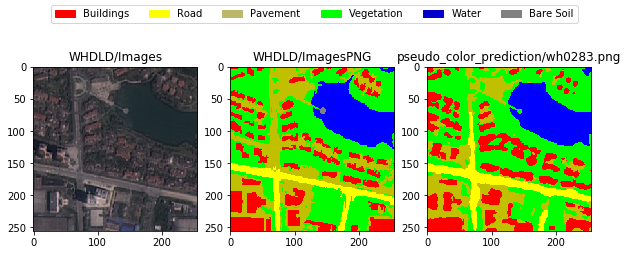

In [21]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# 待可视化的图像列表
img_list = [
    test_data[0][0],
    os.path.join("data/data55589/WHDLD/ImagesPNG", (test_data[0][0][-10:-3] + "png")),
    os.path.join("output/results/pseudo_color_prediction", (test_data[0][0][-10:-3] + "png")),
]

# 可视化
fig = plt.figure(figsize=(10, 7))
# 图例
building = mpatches.Patch(color='red', label='Buildings')
road = mpatches.Patch(color='yellow', label='Road')
pavement = mpatches.Patch(color='darkkhaki', label='Pavement')
vegetation = mpatches.Patch(color='lime', label='Vegetation')
water = mpatches.Patch(color='mediumblue', label='Water')
soil = mpatches.Patch(color='grey', label='Bare Soil')
fig.legend(
    handles=[building, road, pavement, vegetation, water, soil],
    loc='upper center',
    ncol=6
)
# 拼接子图 左/中/右: 原图/原标注/伪彩色预测效果
cnt = 0
for i in img_list:
    img = plt.imread(i)
    plt.subplot(231 + cnt)  # 拼接子图
    plt.title(i.split('/')[2] + "/" + i.split('/')[3])
    plt.imshow(img)
    cnt += 1

## 七、总结
本项目仅用来熟悉PaddleSeg使用流程，日后有机会会对模型进行进一步优化。

- 作者：储氢合金M.H.
- 山西农业大学本科生
- 兴趣方向：计算机视觉，学习视觉SLAM与深度学习结合ing
- 个人主页：
	- [GitHub](https://github.com/NEKOAKIKI)
   - [Gitee](https://gitee.com/nekoakiki)
	- [飞桨AI Studio](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/771061)